In [1]:
import os
import utils.trees as ut
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_rel

In [2]:
results = "../nextflow/results/"
ranking_subdir = 'naive_reversions_first'
outbase = "output/fitness-regression/"
metadata_csv = "../gc_metadata.csv"

In [3]:
# Parameters
results = "."
ranking_subdir = "naive_reversions_first"
metadata_csv = "gc_metadata.csv"
outbase = "."


In [4]:
output_dir = f"{outbase}/{ranking_subdir}"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [5]:
metadata = pd.read_csv(metadata_csv, index_col=0)
metadata.query("(strain == 'wt') & (cell_type == 'GC') & (imm_duration != 'w10')", inplace=True)
metadata.rename(columns={'imm_duration': 'time'}, inplace=True)
metadata

,ngs_id,time,mouse,gc,strain,node,cell_type,plate,hc_barcode,lc_barcode,row,col
uid,,,,,,,,,,,,
D15_M1_GC1,PR-2-01,d15,1,1,wt,RP,GC,2,9,9,A.B.C.D.E.F.G.H,1.2.3.4.5.6.7.8.9.10.11.12
D15_M1_GC2,PR-2-01,d15,1,2,wt,RI,GC,3,2,1,A.B.C.D.E.F.G.H,1.2.3.4.5.6.7.8.9.10.11.12
D15_M1_GC3,PR-2-01,d15,1,3,wt,LI,GC,4,14,2,A.B.C.D.E.F.G.H,1.2.3.4.5.6.7.8.9.10.11.12
D15_M2_GC4,PR-2-01,d15,2,4,wt,RP,GC,5,10,11,A.B.C.D.E.F.G.H,1.2.3.4.5.6.7.8.9.10.11.12
D15_M3_GC5,PR-2-01,d15,3,5,wt,RP,GC,6,7,4,A.B.C.D.E.F.G.H,1.2.3.4.5.6.7.8.9.10.11.12
...,...,...,...,...,...,...,...,...,...,...,...,...
D20_M24_GC115,PR-1-04,d20,24,115,wt,RP,GC,72,16,16,A.B.C.D.E.F.G.H,1.2.3.4.5.6.7.8.9.10.11.12
D20_M25_GC116,PR-1-02,d20,25,116,wt,RP,GC,65,8,8,A.B.C.D.E.F.G.H,1.2.3.4.5.6.7.8.9.10.11.12
D20_M25_GC117,PR-1-03,d20,25,117,wt,RP,GC,68,9,9,A.B.C.D.E.F.G.H,1.2.3.4.5.6.7.8.9.10.11.12


## Load trees from results directory

In [6]:
trees = ut.load_trees(metadata, results, ranking_subdir)
print(f"loaded {len(trees)} GC trees out of {len(metadata)} in metadata")

loaded 119 GC trees out of 119 in metadata


## Affinity node feauture

In [7]:
delta_bind_attr = "delta_bind"

## Data frame with a row for each node on each tree

In [8]:
rows = []
for gc, tree in trees.items():    
    total_abundance = sum(node.abundance for node in tree.tree.traverse())

    for node in tree.tree.traverse():
        
            root_distance_nt = node.get_distance(tree.tree)

            descendant_distances_nt = [node.get_distance(descendant)
                                       for descendant in node.traverse()
                                       if descendant.abundance]
            
            closest_leaf_distance_nt = min(descendant_distances_nt)
            farthest_leaf_distance_nt = max(descendant_distances_nt)
            
            branch_length = sum(node.dist for node in tree.tree.traverse())

            # compare nodes (e.g. bursts) with their sisters
            if node.up is not None and len(node.up.children) > 1:
                mean_sister_delta_bind = np.nanmean([getattr(node2, delta_bind_attr)
                                                for node2 in node.up.children
                                                if node2.name != node.name])
            else:
                mean_sister_delta_bind = np.nan
            
            rows.append([gc,
                         metadata.time[gc],
                         node.name,
                         node.up.name if node.up else np.nan,
                         ";".join(node.mutations),
                         ";".join(set(node.mutations) - (set(node.up.mutations) if node.up is not None else set())),
                         ";".join((set(node.up.mutations) if node.up is not None else set()) - set(node.mutations)),
                         node.abundance,
                         len(node.children),
                         node.abundance + len(node.children),
                         node.LBI,
                         node.LBR,
                         node.REI,
                         sum(node.LB_down.values()) / branch_length,
                         root_distance_nt,
                         closest_leaf_distance_nt,
                         farthest_leaf_distance_nt,
                         getattr(node, delta_bind_attr),
                         getattr(node.up, delta_bind_attr) if node.up else np.nan,
                         getattr(node, delta_bind_attr) - getattr(node.up, delta_bind_attr) if node.up is not None else np.nan,
                         node.delta_expr,
                         mean_sister_delta_bind,
                        ])

df = pd.DataFrame(rows, columns=["GC",
                                 "time",
                                 "name",
                                 "parent_name",
                                 "aa_mutations",
                                 "aa_mutations_edge_gained",
                                 "aa_mutations_edge_lost",
                                 "abundance",
                                 "n_mutant_edges",
                                 "polytomy_degree",
                                 "LBI",
                                 "LBR",
                                 "REI",
                                 "LBF",
                                 "root_distance_nt",
                                 "closest_leaf_distance_nt",
                                 "farthest_leaf_distance_nt",
                                 "delta_bind",
                                 "parent_delta_bind",
                                 "delta_bind_edge",
                                 "delta_expr",
                                 "mean_sister_delta_bind",
                                ])

df

/tmp/ipykernel_350/1657210563.py:20: RuntimeWarning: Mean of empty slice
  mean_sister_delta_bind = np.nanmean([getattr(node2, delta_bind_attr)


,GC,time,name,parent_name,aa_mutations,aa_mutations_edge_gained,aa_mutations_edge_lost,abundance,n_mutant_edges,polytomy_degree,...,REI,LBF,root_distance_nt,closest_leaf_distance_nt,farthest_leaf_distance_nt,delta_bind,parent_delta_bind,delta_bind_edge,delta_expr,mean_sister_delta_bind
0,D15_M1_GC1,d15,naive,NaN,,,,0,11,11,...,0.082323,0.107784,0.0,1.0,9.0,0.00000,NaN,NaN,0.00000,NaN
1,D15_M1_GC1,d15,seq18,naive,Q8(L)H;K9(L)T,Q8(L)H;K9(L)T,,1,0,1,...,0.014925,0.000000,3.0,0.0,0.0,0.02218,0.00000,0.02218,0.13093,0.000163
2,D15_M1_GC1,d15,seq35,naive,S64(H)N;L116(L)P;L124(L)V,S64(H)N;L124(L)V;L116(L)P,,1,0,1,...,0.014925,0.000000,3.0,0.0,0.0,0.09485,0.00000,0.09485,-0.00361,-0.007104
3,D15_M1_GC1,d15,seq48,naive,S128(H)L;T37(L)S;Q44(L)H;N108(L)S,T37(L)S;N108(L)S;S128(H)L;Q44(L)H,,1,0,1,...,0.014925,0.000000,4.0,0.0,0.0,0.75640,0.00000,0.75640,-0.05788,-0.073259
4,D15_M1_GC1,d15,seq15,naive,K84(H)R;R106(H)K;K123(L)E,R106(H)K;K123(L)E;K84(H)R,,1,0,1,...,0.014925,0.000000,3.0,0.0,0.0,-0.37822,0.00000,-0.37822,-0.02799,0.040203
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9707,D20_M25_GC119,d20,seq22,seq14,S57(H)N;A105(H)G;T37(L)S;A52(L)S;S92(L)T;E101(...,A52(L)S;E101(L)D;T37(L)S;S57(H)N,,1,0,1,...,0.012346,0.000000,13.0,0.0,0.0,1.68377,1.03820,0.64557,-0.12751,1.221785
9708,D20_M25_GC119,d20,seq25,seq14,A105(H)G;S92(L)T;Q105(L)H;S109(L)I,,,1,0,1,...,0.012346,0.000000,9.0,0.0,0.0,1.03820,1.03820,0.00000,0.02679,1.383177
9709,D20_M25_GC119,d20,seq45,seq14,A105(H)G;S92(L)T;A100(L)G;Q105(L)H;S109(L)M,S109(L)M;A100(L)G,S109(L)I,1,0,1,...,0.012346,0.000000,10.0,0.0,0.0,1.29038,1.03820,0.25218,0.02708,1.320133
9710,D20_M25_GC119,d20,seq70,seq14,A105(H)G;T88(L)A;S92(L)T;Q105(L)H;N108(L)I;S10...,T88(L)A;N108(L)I,,1,0,1,...,0.012346,0.000000,11.0,0.0,0.0,1.52036,1.03820,0.48216,0.07518,1.262638


In [9]:
# check that names are unique
df.groupby(["GC", "name"]).size().unique()

array([1])

In [10]:
df.to_csv(f"{output_dir}/data.csv", index=False)

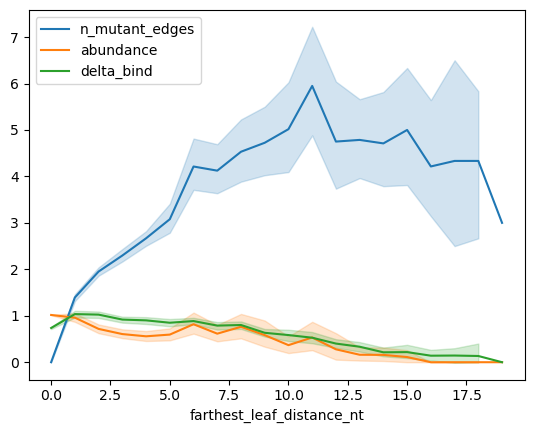

In [11]:
sns.lineplot(data=df, x="farthest_leaf_distance_nt", y="n_mutant_edges", label="n_mutant_edges")
sns.lineplot(data=df, x="farthest_leaf_distance_nt", y="abundance", label="abundance")
sns.lineplot(data=df, x="farthest_leaf_distance_nt", y="delta_bind", label="delta_bind")
plt.ylabel("")
plt.show()

<Axes: xlabel='farthest_leaf_distance_nt', ylabel='REI'>

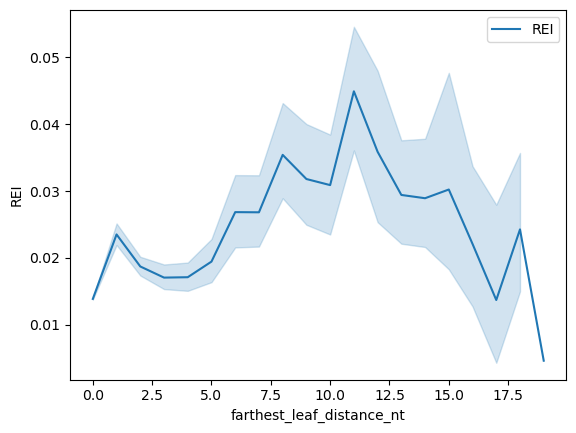

In [12]:
sns.lineplot(data=df, x="farthest_leaf_distance_nt", y="REI", label="REI")

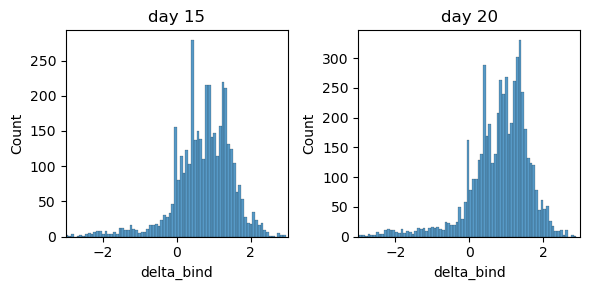

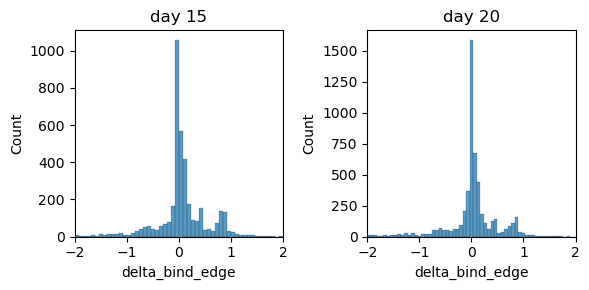

In [13]:
plt.figure(figsize=(6, 3))
plt.subplot(121)
sns.histplot(data=df.query("time=='d15'"), x="delta_bind", bins=120)
plt.title("day 15")
plt.xlim(-3, 3)
plt.subplot(122)
sns.histplot(data=df.query("time=='d20'"), x="delta_bind", bins=120)
plt.title("day 20")
plt.xlim(-3, 3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 3))
plt.subplot(121)
sns.histplot(data=df.query("time=='d15'"), x="delta_bind_edge", bins=120)
plt.title("day 15")
plt.xlim(-2, 2)
plt.subplot(122)
sns.histplot(data=df.query("time=='d20'"), x="delta_bind_edge", bins=120)
plt.title("day 20")
plt.xlim(-2, 2)
plt.tight_layout()
plt.show()

d15


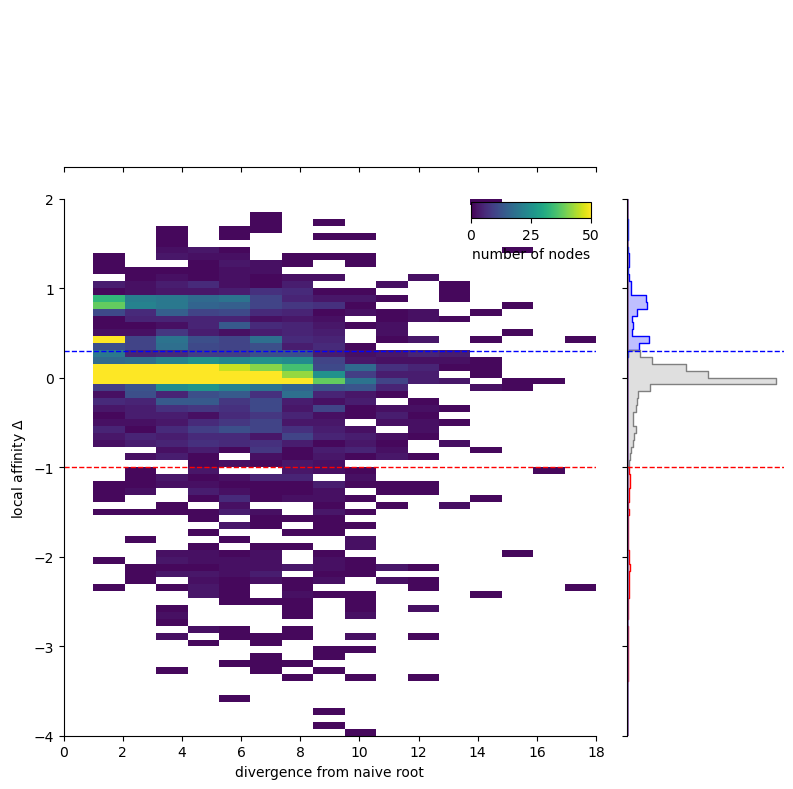

d20


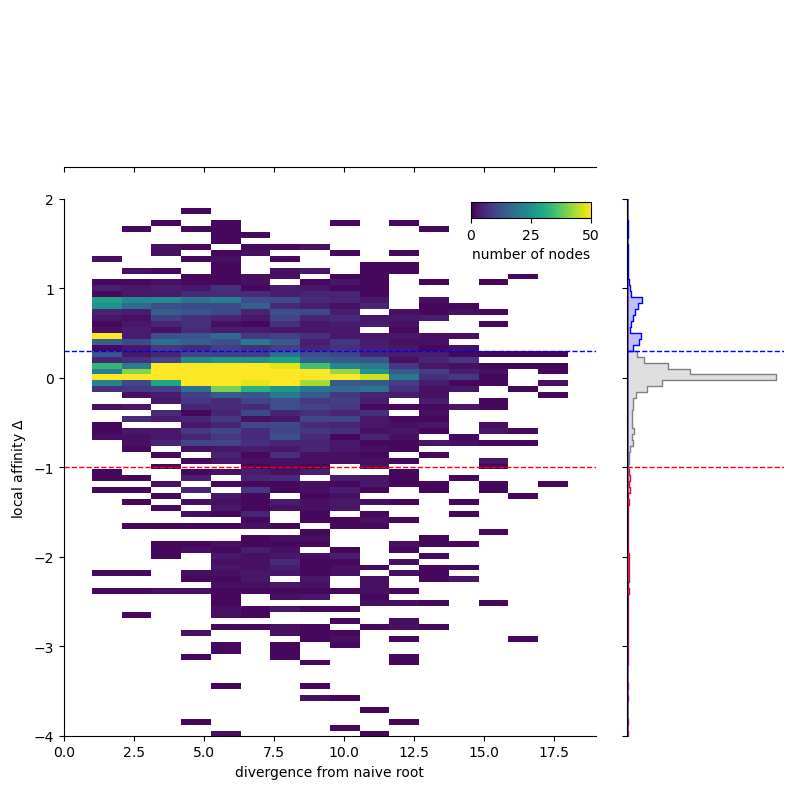

In [14]:
gain_thresh = 0.3
loss_thresh = -1

# absolute affinity strata
df.loc[~df.delta_bind.isna(), "affinity stratum"] = "affinity neutral"
df.loc[df["delta_bind"] > gain_thresh, "affinity stratum"] = "affinity gain"
df.loc[df["delta_bind"] < loss_thresh, "affinity stratum"] = "affinity loss"

# affinity change strata
df.loc[~df.delta_bind_edge.isna(), "affinity change stratum"] = "affinity neutral"
df.loc[df["delta_bind_edge"] > gain_thresh, "affinity change stratum"] = "affinity gain"
df.loc[df["delta_bind_edge"] < loss_thresh, "affinity change stratum"] = "affinity loss"
palette = {"affinity loss": "red", "affinity neutral": "grey", "affinity gain": "blue"}

for time in ("d15", "d20"):
    print(time)
    df_time = df.query(f"time=='{time}'")
    g = sns.JointGrid(data=df_time,
                      x="root_distance_nt",
                      y="delta_bind_edge",
                      xlim=(0, df_time.root_distance_nt.max()),
                      ylim=(-4, 2),
                      height=8, ratio=3)
    g = g.plot_joint(sns.histplot,
                    bins=(16, 120),
                    vmax=50,
                    cmap="viridis",
                    cbar=True,                 
                    cbar_ax=plt.gcf().add_axes([0.59, 0.72, 0.15, 0.02]),
                    cbar_kws=dict(orientation='horizontal', label="number of nodes"),
                    )
    sns.histplot(ax=g.ax_marg_y,
                y=df_time.loc[~df_time.delta_bind_edge.isna(), "delta_bind_edge"],
                hue=df_time.loc[~df_time.delta_bind_edge.isna(), "affinity change stratum"],
                bins=120,
                palette=palette,
                fill=True, element="step", linewidth=1,
                legend=False)
    g.ax_marg_y.axhline(gain_thresh, c="blue", ls="--", lw=1)
    g.ax_marg_y.axhline(loss_thresh, c="red", ls="--", lw=1)
    g.ax_joint.axhline(gain_thresh, c="blue", ls="--", lw=1)
    g.ax_joint.axhline(loss_thresh, c="red", ls="--", lw=1)
    g.set_axis_labels(
        "divergence from naive root",
        r"local affinity $\Delta$",
        )
    plt.savefig(f"{output_dir}/heatmap_{time}.pdf")
    plt.show()

d15


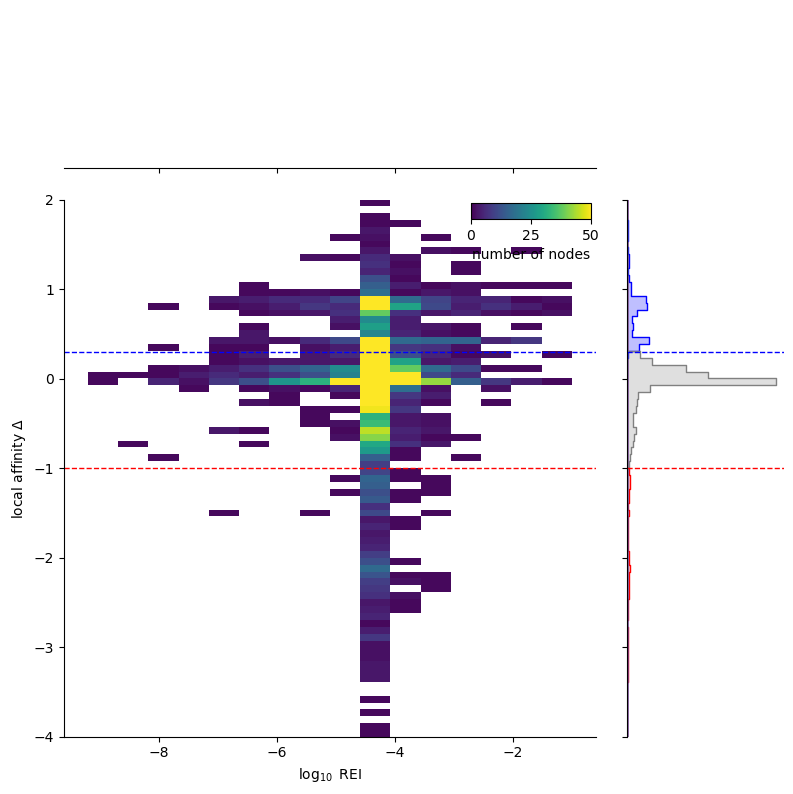

d20


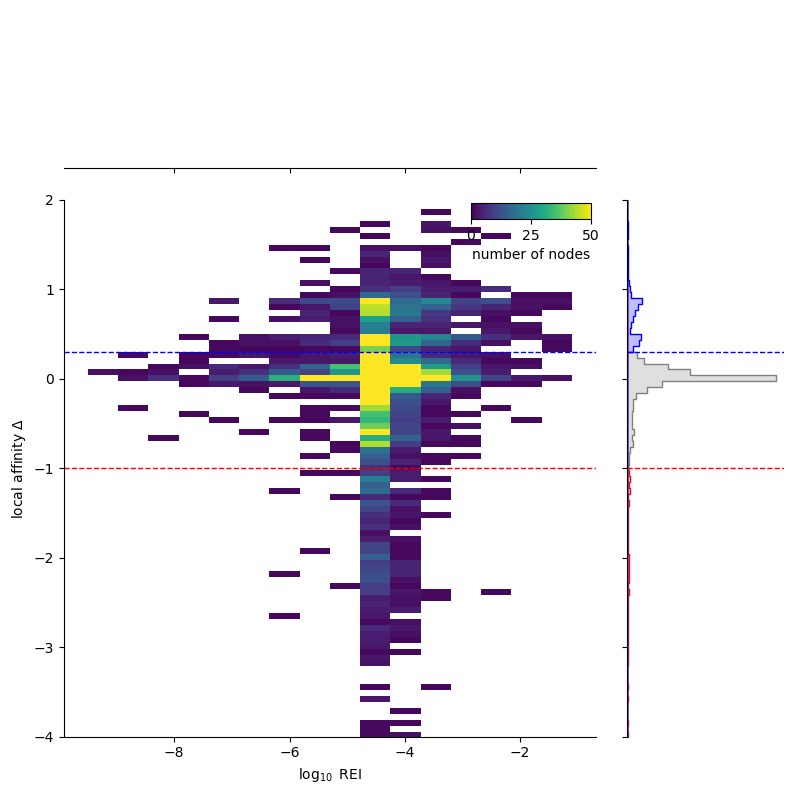

In [15]:
for time in ("d15", "d20"):
    print(time)
    df_time = df.query(f"time=='{time}'")
    g = sns.JointGrid(data=df_time, x=np.log(df_time.REI),
                      y="delta_bind_edge",
                      ylim=(-4, 2),
                      height=8, ratio=3)
    g = g.plot_joint(sns.histplot,
                    bins=(16, 120),
                    vmax=50,
                    cmap="viridis",
                    cbar=True,                 
                    cbar_ax=plt.gcf().add_axes([0.59, 0.72, 0.15, 0.02]),
                    cbar_kws=dict(orientation='horizontal', label="number of nodes"),
                    )
    sns.histplot(ax=g.ax_marg_y,
                y=df_time.loc[~df_time.delta_bind_edge.isna(), "delta_bind_edge"], hue=df_time.loc[~df_time.delta_bind_edge.isna(), "affinity change stratum"],
                bins=120,
                palette=palette,
                fill=True, element="step", linewidth=1,
                legend=False)
    g.ax_marg_y.axhline(gain_thresh, c="blue", ls="--", lw=1)
    g.ax_marg_y.axhline(loss_thresh, c="red", ls="--", lw=1)
    g.ax_joint.axhline(gain_thresh, c="blue", ls="--", lw=1)
    g.ax_joint.axhline(loss_thresh, c="red", ls="--", lw=1)
    g.set_axis_labels(r"$\log_{10}$ REI", r"local affinity $\Delta$")
    plt.savefig(f"{output_dir}/heatmap2_{time}.pdf")
    plt.show()

d15


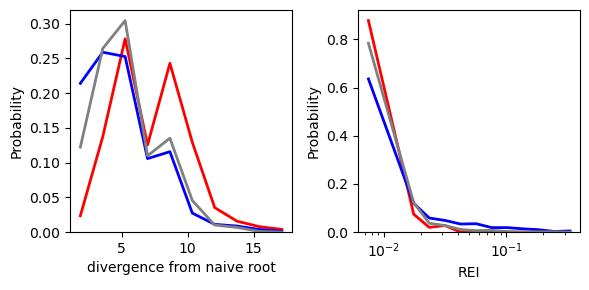

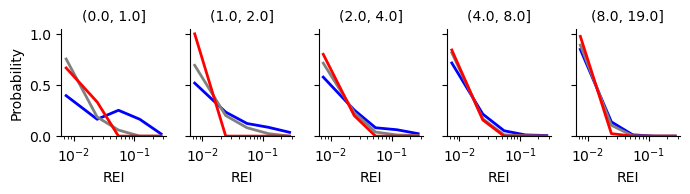

d20


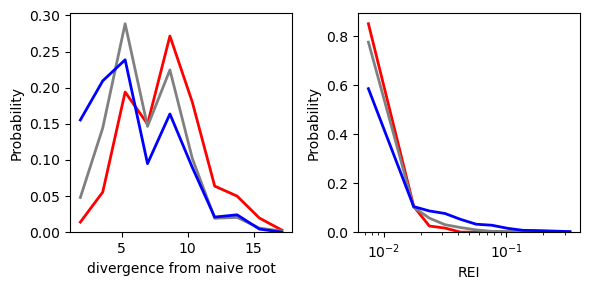

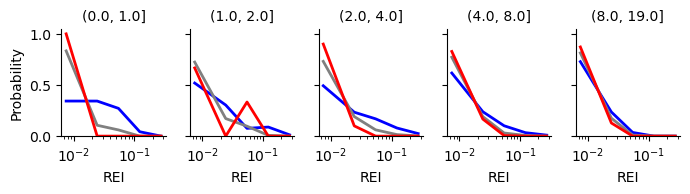

In [16]:
df["divergence stratum"] = pd.cut(df.root_distance_nt, [0, 1, 2, 4, 8, df.root_distance_nt.max()])
df["leaf distance stratum"] = pd.cut(df.farthest_leaf_distance_nt, [0, 2, 5, 10, df.farthest_leaf_distance_nt.max()])

# branching_stat = "LBI"
# branching_stat = "LBR"
branching_stat = "REI"

linthresh = 0.015
bins1 = [0] + list(np.geomspace(linthresh, df[branching_stat].max() + .01, 12))
bins2 = [0] + list(np.geomspace(linthresh, df[branching_stat].max() + .01, 5))

for time in ("d15", "d20"):
    print(time)
    df_time = df.query(f"time=='{time}'")

    plt.figure(figsize=(6, 3))

    plt.subplot(121)
    sns.histplot(data=df_time.loc[~df_time.delta_bind_edge.isna()],
                x="root_distance_nt",
                hue="affinity change stratum",
                bins=10,
                stat="probability", common_norm=False,
                palette=palette,
                fill=False, element="poly", linewidth=2,
                legend=False)
    plt.xlabel("divergence from naive root")

    plt.subplot(122)
    sns.histplot(data=df_time.loc[~df_time.delta_bind_edge.isna()], x=branching_stat,
                hue="affinity change stratum",
                bins=bins1,
                stat="probability", common_norm=False,
                palette=palette,
                fill=False, element="poly", linewidth=2,
                legend=False)
    plt.xlabel(branching_stat)
    plt.xscale("log")
    plt.tight_layout()
    plt.savefig(f"{output_dir}/divergence-{branching_stat}_{time}.pdf")
    plt.show()

    g = sns.displot(data=df_time.loc[~df_time.delta_bind_edge.isna()],
                col="divergence stratum",
                x=branching_stat,
                hue="affinity change stratum",
                hue_order=palette.keys(),
                palette=palette,
                bins=bins2,
                stat="probability",
                common_norm=False,
                aspect=0.7, height=2,
                fill=False, element="poly", linewidth=2,
                legend=False
            )
    g.set_titles(col_template="{col_name}")
    plt.xscale("log")
    plt.savefig(f"{output_dir}/divergence-stratified-{branching_stat}_{time}.pdf")
    plt.show()

d15
REI: p=0.19


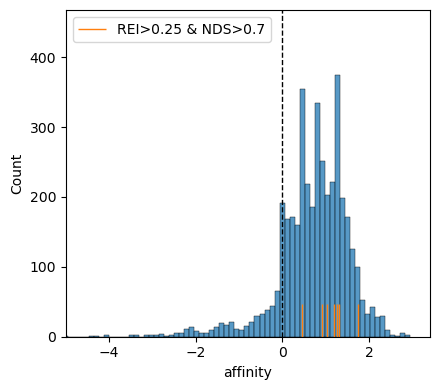

d20
REI: p=0.24


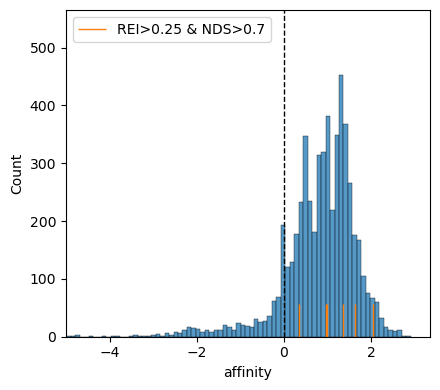

In [17]:
from scipy.stats import ttest_ind

top = 20

REI_thresh = 0.25
NDS_thresh = 0.7

for time in ("d15", "d20"):
    print(time)
    df_time = df.query(f"time=='{time}'")
    df_time_top = df_time.query(f"REI>{REI_thresh} & LBR>{NDS_thresh}")

    plt.figure(figsize=(4.5, 4))
    sns.histplot(data=df_time, x="delta_bind")
    sns.rugplot(data=df_time_top, x="delta_bind", color="C1", height=0.1, label=f"REI>{REI_thresh} & NDS>{NDS_thresh}", lw=2)
    plt.axvline(0, c="k", ls="--", lw=1)
    plt.xlabel("affinity")
    plt.xlim(-5, None)
    plt.legend(loc="upper left")

    print(f'REI: p={ttest_ind(df_time_top.delta_bind, df_time.delta_bind[~df_time.index.isin(df_time_top.index)], nan_policy="omit").pvalue:.2f}')

    plt.tight_layout()

    plt.savefig(f"{output_dir}/topREI_{time}.pdf")
    plt.show()

### Comparison to sisters

For statistical independence, we can only take one node—the max REI node—from each tree

d15


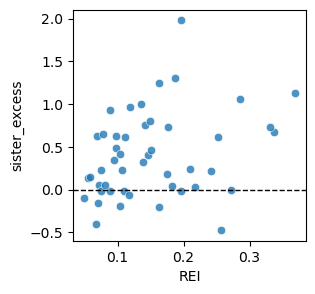

TtestResult(statistic=np.float64(nan), pvalue=np.float64(nan), df=np.float64(nan))

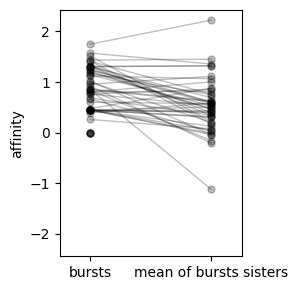

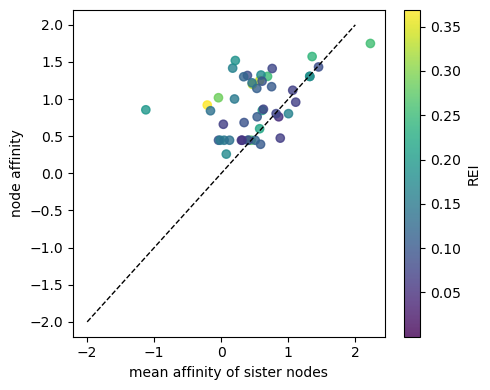

d20


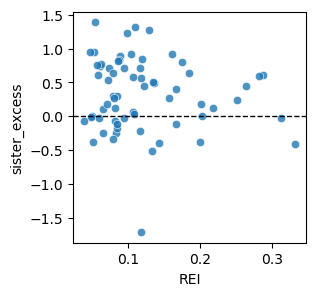

TtestResult(statistic=np.float64(nan), pvalue=np.float64(nan), df=np.float64(nan))

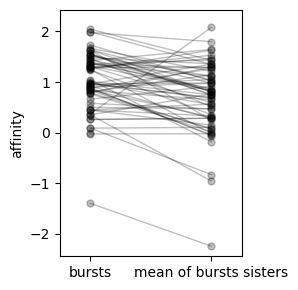

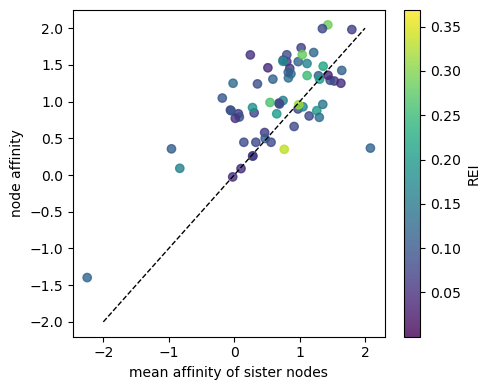

In [18]:
for time in ("d15", "d20"):
    print(time)
    df_time = df.query(f"time=='{time}'")

    # max REI row per GC
    df_max = df_time.loc[df_time.groupby("GC")["REI"].idxmax()]

    df_max["sister_excess"] = df_max.delta_bind - df_max.mean_sister_delta_bind

    # df_max = df_max[["delta_bind", "mean_sister_delta_bind", "sister_excess", "REI"]].dropna()

    df_max.to_csv(f"{output_dir}/data_maxREI_{time}.csv", index=False)

    # plot of sister excess vs. REI
    plt.figure(figsize=(3, 3))
    sns.scatterplot(data=df_max,
                    y="sister_excess", x="REI", alpha=0.8)
    plt.axhline(0, c="k", ls="--", lw=1)
    plt.show()

    # two sample test
    # df_max_nonan = df_max[["delta_bind", "mean_sister_delta_bind"]].dropna()
    display(ttest_rel(df_max.delta_bind, df_max.mean_sister_delta_bind, alternative="greater"))

    plt.figure(figsize=(3, 3))
    plt.plot([[0, 1]] * len(df_max), df_max[["delta_bind", "mean_sister_delta_bind"]].values, "o", c="k", ms=5, alpha=0.25)
    for i, (x, y) in enumerate(df_max[["delta_bind", "mean_sister_delta_bind"]].values):
        plt.plot([0, 1], [x, y], c="k", lw=1, alpha=0.25)
    plt.xticks([0, 1], ["bursts", "mean of bursts sisters"])
    plt.ylabel("affinity")
    plt.xlim(-0.25, 1.25)
    plt.ylim(df.loc[df.groupby("GC")["REI"].idxmax()][["delta_bind", "mean_sister_delta_bind"]].min().min() - 0.2, df.loc[df.groupby("GC")["REI"].idxmax()][["delta_bind", "mean_sister_delta_bind"]].max().max() + 0.2)
    plt.tight_layout()
    plt.savefig(f"{output_dir}/sister-affinity_{time}.pdf")
    plt.show()

    plt.figure(figsize=(5, 4))
    plt.scatter(data=df_max, y="delta_bind", x="mean_sister_delta_bind", c="REI", cmap="viridis", alpha=0.8, vmin=df.REI.min(), vmax=df.REI.max())
    plt.colorbar(label="REI")
    plt.plot([-2, 2], [-2, 2], c="k", ls="--", lw=1)
    plt.xlabel("mean affinity of sister nodes")
    plt.ylabel("node affinity")
    plt.tight_layout()
    plt.savefig(f"{output_dir}/sister-affinity2_{time}.pdf")
    plt.show()

## Are terrible nodes usually leaves? 

Note: need to aggregate to a GC-level metric, so we can properly test

d15


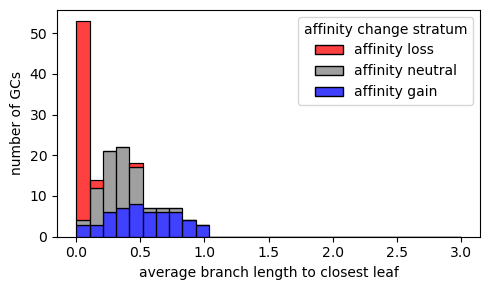

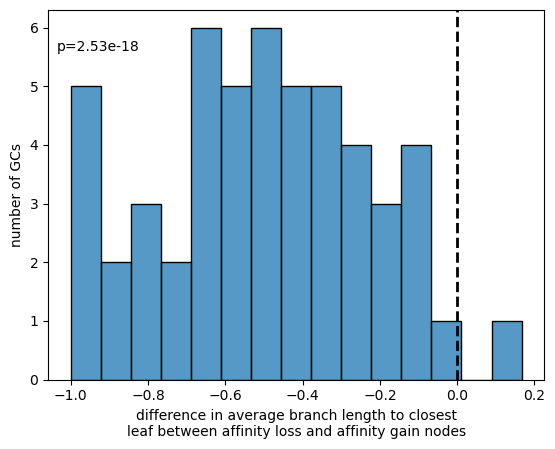

d20


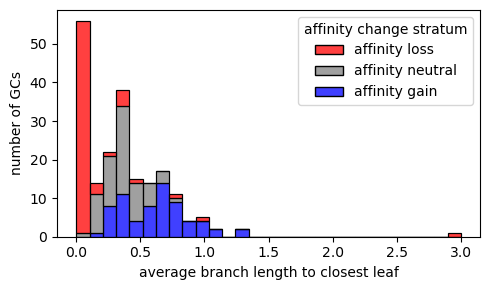

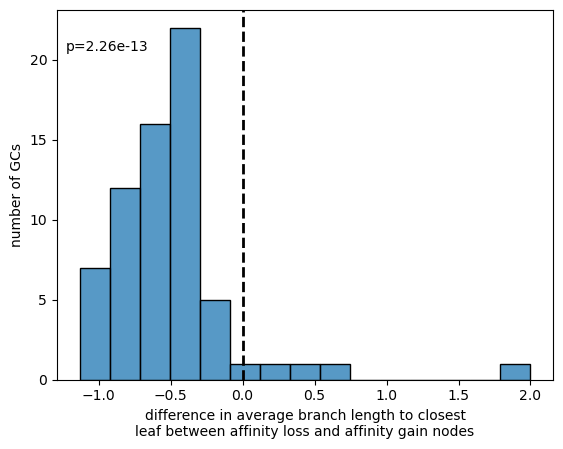

In [19]:
for time in ("d15", "d20"):
    print(time)
    df_time = df.query(f"time=='{time}'")

    df_groups = df_time.groupby(["GC", "affinity change stratum"]).closest_leaf_distance_nt.mean().reset_index()

    plt.figure(figsize=(5, 3))
    sns.histplot(data=df_groups,
                  hue="affinity change stratum", x="closest_leaf_distance_nt",
                  hue_order=("affinity loss", "affinity neutral", "affinity gain"),
                  multiple="stack",
                  bins=np.linspace(0, df.groupby(["GC", "affinity change stratum"]).closest_leaf_distance_nt.mean().max(), 30),
                  palette=palette,
                  )
    plt.xlabel("average branch length to closest leaf")
    plt.ylabel("number of GCs")
    plt.tight_layout()
    plt.savefig(f"{output_dir}/terrible-histogram_{time}.pdf")
    plt.show()

    diff_stat = df_groups.query("`affinity change stratum` == 'affinity loss'").set_index("GC").closest_leaf_distance_nt - df_groups.query("`affinity change stratum` == 'affinity gain'").set_index("GC").closest_leaf_distance_nt

    from scipy.stats import ttest_1samp

    p = ttest_1samp(diff_stat, 0).pvalue

    sns.histplot(diff_stat, bins=15)
    plt.xlabel("difference in average branch length to closest\nleaf between affinity loss and affinity gain nodes")
    plt.ylabel("number of GCs")
    plt.axvline(0, c="k", ls="--", lw=2)
    plt.annotate(f"p={p:.2e}", (0.1, 0.9), xycoords="axes fraction", va="center", ha="center")
    plt.savefig(f"{output_dir}/terrible-significance_{time}.pdf")
    plt.show()